L'idée est de créer des séries synthétiques (et donc labelisées 0). Pour ça j'ai mélangé les données, puis additionné les séries propres et les séries obtenues.

In [37]:
from sklearn.utils import shuffle
X  = shuffle(df.reshape(-1,1),  random_state=0) # shuffle = mélange 

In [30]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


C:\Users\Dany\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


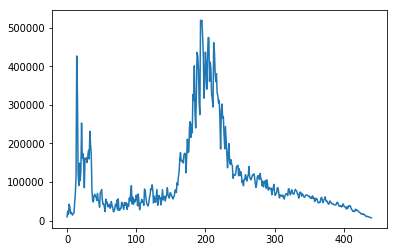

In [31]:
plt.plot(df[0,:])

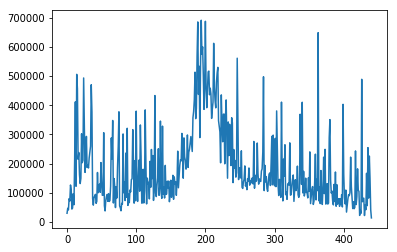

In [52]:
X_ = df.reshape(-1,441) + X.reshape(-1,441)

plt.plot(X_[0,:]) # la même série mais bruitée

J'ai entraîné le model sur les fenêtres coulissantes, obtenues sur le mélange des données normales et bruitées, donc certaines sont complètement bruités, d'autres pas du tout, d'autres sont un mélange des deux, ou de deux séries normales, etc. J'ai utilisé un random forest, un modèle simple. 

Le résultat est obtenu sur la moyenne de validations croisées (une k validation croisée correspond à un découpage des données en k parties, l'algorithm utilisant k-1 parties pour s'entraîner et donc 1 partie pour tester le model. Ici il le fait 10 fois, l'intérêt étant de s'entraîner et de se tester à chaque fois sur un ensemble de données différent ==> previent l'overfitting et permet d'appréçier correctement l'efficacité du model) 

Pour obtenir des probabilités ==> model.fit puis model.predict (binaire) ou model.predict_proba (si tu veut instaurer une règle de décision perso, ex : p > 0.90 == 1, 0 sinon, la régle de base de scikit étant p > 0.5 pour 1)

J'ai utilisé les 200 premières séries du tableau de base (normales et bruitées), ça me donne 87 759 nouvelles séries... le modèle met 5 bonnes minutes à tourner.

In [40]:
# regroupement des données d'origines et bruitées, pareil pour les labels
labels = np.concatenate((np.ones((724,)), np.zeros((724,))), axis = 0)
X_all = np.concatenate((df.reshape(-1,441),X_), axis = 0) 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle



#mélange des données et labels 
X_t,  y = shuffle(X_all,  labels, random_state=0)

# "moving windows" une fonction qui permet de faire des fenêtres de longueur p avec un décalage de 1 à chaque fois
def load_data(stock, seq_len):
    data = stock
    sequence_length = seq_len  
    result = []
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    train = np.array(result)
    X_train = np.reshape(train, (train.shape[0], train.shape[1]))
    
    return X_train

# je prends les 200 premières séries, ça permet d'avoir 87 759 nouvelles séries...
x_t = load_data(X_t[:200].reshape(-1,1), 441)

#je crée des labels pour retrouver les bonnes séries (ex : si les 2 premières séries dans X sont justes, 
#la 1ere et la 441eme de x_t le seront aussi)

l = np.zeros((len(x_t)))
for i in range(len(y[:200])):
    if y[i] == 1 :
        l[i*441] =1

# le random forest 
clf = RandomForestClassifier(n_estimators=50)

scores = cross_val_score(clf, x_t, l, cv = 10)
scores.mean()

0.9985642531950646

Ce score paraît énorme : il n'y a que 100 bonnes séries dans le dataset, contre 87000 environ pour le label 0. 
Pour obtenir une matrice de confusion

In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(clf,x_t,l,cv=10)
conf_mat = confusion_matrix(l,y_pred)

In [42]:
print(conf_mat)

[[87650     9]
 [   99     1]]


Il n'a pu détecter qu'une seule bonne série... un problème classique quand ton dataset n'est pas "balanced". 

En résumé, 3 axes te permettent d'améliorer le model : 

- la qualité de tes données d'entraînement. Tu peux toujours rajouter des spectres comme tu as enregistré (bruits de bouches, tv, etc), ça n'en sera que meilleur. 
- "assouplir" la règle de décision, accepter que des séries très proches des bonnes séries le soient aussi (si la séries 50 est bonne, mettre des labels 1 pour les 10 séries avant et après par exemple ==> ça augmente le nombre de tes séries bonnes, et ça équilibre le dataset un peu entre les positifs et négatifs). Ou alors, rebalancer le dataset avec une librairie comme imblearn (cf ensuite).
- le modèle et ses paramètres


Un exemple pour équilibrer le dataset, l'algo SMOTE (imblearn), y'a la doc ici http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py

C'est du resampling basé sur de l'interpolation linéaire. L'idée est que l'algo va créer des séries synthétiques à partir de la calsse minoritaire (ici les séries normales donc), pour obtenir autant de séries de chaque (87000/87000). Tu gagnes des séries "bonnes" mais synthétiques. 

In [46]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(x_t[:10000], l[:10000]) #sur un échantillon seulement
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({1.0: 9988, 0.0: 9988})


In [48]:
from sklearn.utils import shuffle
X_res, y_res = shuffle(X_res,  y_res, random_state=0)

clf = RandomForestClassifier(n_estimators=50)
scores = cross_val_score(clf, X_res, y_res, cv = 5)
scores.mean()

0.9998998748372809

In [50]:

y_pred = cross_val_predict(clf,X_res, y_res,cv=5)
conf_mat = confusion_matrix(y_res,y_pred)
print(conf_mat)

[[9988    0]
 [   0 9988]]


Mieux :) 